In [2]:
import numpy as np
import matplotlib.pyplot as plt
from MazeEnvironment import MazeEnv, CustomVecMonitor
from plots import *

import torch
import torch.nn as nn

from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor
from stable_baselines3 import PPO, DQN

from gymnasium import spaces

from FeatureExtractor import FeatureExtractor

import json

In [3]:
CONFIG = {
    'train_test_split': 0.95,
    'training_env': {
        'n_envs': 2,
        'do_dfs': True,
        'seed': 60,
        
        'env_params_with_dfs': {
            'rew_weights': {
                'base': -0.001,
                'goal': 5.00,
                'wall': -2.00,
                'new_cell': 0.005,
                'distance': -0.01
            },
            'dfs_dist': True,
            'end_on_wall': True,
        },
        'env_params_no_dfs': {
            'rew_weights': {
                'base': -0.01,
                'goal': 1.00,
                'wall': -1.00,
                'new_cell': 0.01,
                'distance': -0.0001
            },
            'dfs_dist': False,
            'end_on_wall': False,
        }
    }
}

In [4]:
maze_img_path = 'Data/maze_imgs.npy'
maze_arr_path = 'Data/mazes.npy'

maze_imgs = np.load(maze_img_path)
maze_arrs = np.load(maze_arr_path)

split_ratio = CONFIG['train_test_split']

train_maze_imgs = maze_imgs[:int(split_ratio*len(maze_imgs))]
train_maze_arrs = maze_arrs[:int(split_ratio*len(maze_arrs))]

test_maze_imgs = maze_imgs[int(split_ratio*len(maze_imgs)):]
test_maze_arrs = maze_arrs[int(split_ratio*len(maze_imgs)):]

print(f"{len(maze_imgs)} mazes total")
print(f"{len(train_maze_imgs)} training mazes")
print(f"{len(test_maze_imgs)} testing mazes")

3477 mazes total
3303 training mazes
174 testing mazes


In [5]:
def make_env(maze_imgs, maze_arrs, seed, rank, env_params):
    def _init():
        env = MazeEnv(maze_imgs, maze_arrs, seed=seed + rank, **env_params)
        return env
    return _init

n_envs = CONFIG['training_env']['n_envs']
do_dfs = CONFIG['training_env']['do_dfs']
base_seed = CONFIG['training_env']['seed']

if do_dfs: env_params = CONFIG['training_env']['env_params_with_dfs']
else: env_params = CONFIG['training_env']['env_params_no_dfs']

env_fns = [make_env(train_maze_imgs,
                    train_maze_arrs,
                    base_seed, i,
                    env_params) for i in range(n_envs)]

vec_env= SubprocVecEnv(env_fns)
vec_env = CustomVecMonitor(vec_env, 
                           custom_stat_keys = [
                               'base', 'goal', 'wall', 'new_cell', 'distance'
                           ])

In [6]:
dummy_env = MazeEnv(maze_imgs[1:2], maze_arrs[1:2])
dummy_fe = FeatureExtractor(dummy_env.observation_space)
dummy_cnn = dummy_fe.cnn

x = torch.FloatTensor(maze_imgs[0]).unsqueeze(0)
x = torch.permute(x, (0, 3, 1, 2))
print("Input: ", list(x.size()))
for layer in dummy_cnn:
    x = layer(x)
    print(layer)
    print(f"\t{list(x.size())}")

del dummy_env
del dummy_fe
del dummy_cnn

Input:  [1, 3, 90, 90]
Conv2d(3, 8, kernel_size=(6, 6), stride=(1, 1))
	[1, 8, 85, 85]
ReLU()
	[1, 8, 85, 85]
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
	[1, 8, 42, 42]
Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1))
	[1, 16, 37, 37]
ReLU()
	[1, 16, 37, 37]
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
	[1, 16, 18, 18]
Flatten(start_dim=1, end_dim=-1)
	[1, 5184]


In [7]:
load_model = True
load_dir = "Results/PPO/v1"

policy_kwargs = dict(
    features_extractor_class=FeatureExtractor,
    features_extractor_kwargs={
        'debug': False,
        'input_shape': maze_imgs[0].shape,
    }
)
if load_model:
    model_load_path = f"{load_dir}/model"
    model = PPO("MultiInputPolicy", vec_env, policy_kwargs=policy_kwargs, n_steps = 2112, verbose = 1)
    model.set_parameters(model_load_path)
else:
    model = PPO("MultiInputPolicy", vec_env, policy_kwargs=policy_kwargs, n_steps = 2112, verbose = 1)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [79]:
model.learn(total_timesteps=100_000, log_interval = 1)

1278351 images passed.---------------------------------
| rollout/           |          |
|    ep_len_mean     | 6.27     |
|    ep_rew_mean     | -3.92    |
| time/              |          |
|    fps             | 372      |
|    iterations      | 1        |
|    time_elapsed    | 43       |
|    total_timesteps | 16384    |
---------------------------------
1458595 images passed.-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.15        |
|    ep_rew_mean          | -4.16       |
| time/                   |             |
|    fps                  | 63          |
|    iterations           | 2           |
|    time_elapsed         | 518         |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.115992665 |
|    clip_fraction        | 0.38        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.672      |
|    explained_variance   | 

In [8]:
save_dir = "Results/PPO/v1"
model_save_path = f"{save_dir}/model"
stats_save_path = f"{save_dir}/stats.json"
config_save_path = f"{save_dir}/CONFIG.txt"

model.save(model_save_path)

def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj

stats = convert_numpy(vec_env.episode_custom_stats)

os.makedirs(os.path.dirname(stats_save_path), exist_ok=True)
with open(stats_path, "w") as f:
    json.dump(stats, f)

with open(config_save_path, 'w') as f:
    json.dump(CONFIG,f)

NameError: name 'save_path' is not defined

In [9]:
do_dfs = CONFIG['training_env']['do_dfs']
base_seed = CONFIG['training_env']['seed']

if do_dfs: env_params = CONFIG['training_env']['env_params_with_dfs']
else: env_params = CONFIG['training_env']['env_params_no_dfs']

test_env = MazeEnv(test_maze_imgs, test_maze_arrs, base_seed, **env_params)
train_env = MazeEnv(train_maze_imgs, train_maze_arrs, base_seed, **env_params)

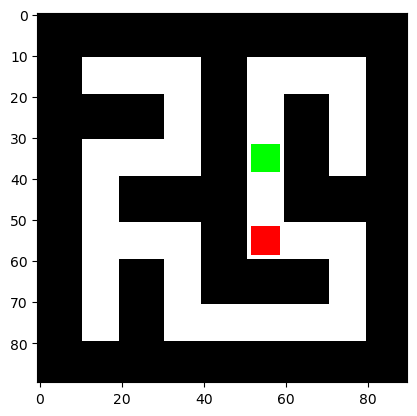

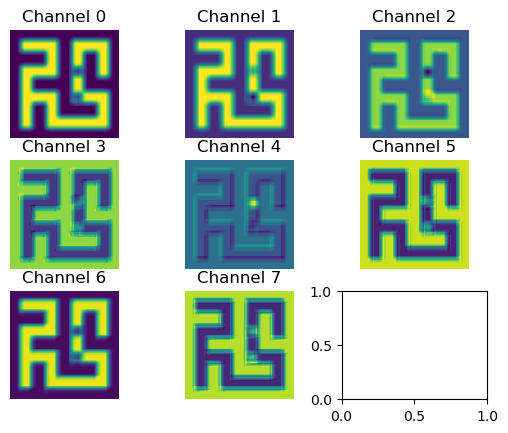

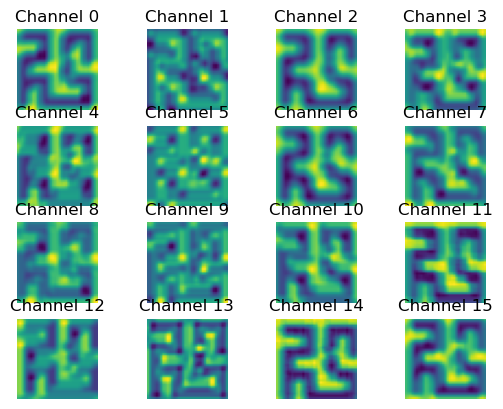

In [10]:
visualize_cnn(test_env, model.policy.features_extractor.cnn, cmap = 'viridis')

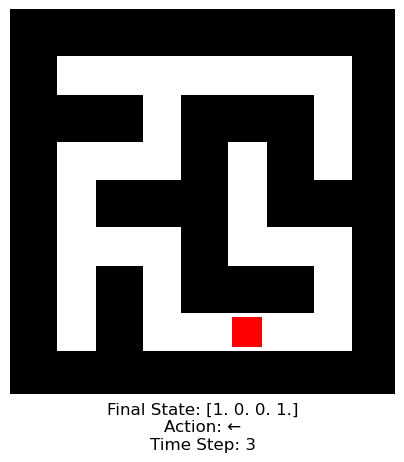

In [24]:
animate_policy(test_env, model, 12, True)

Total timesteps: 3015720
Total episodes: 466678


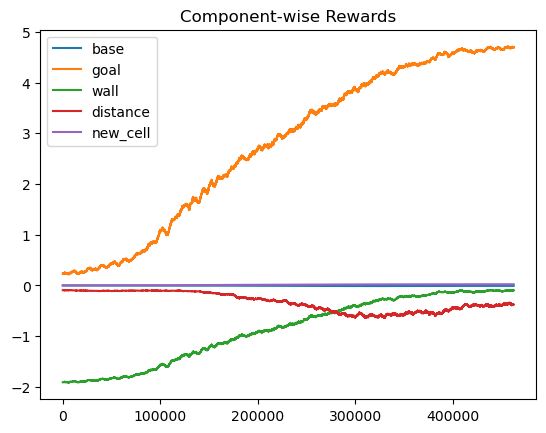

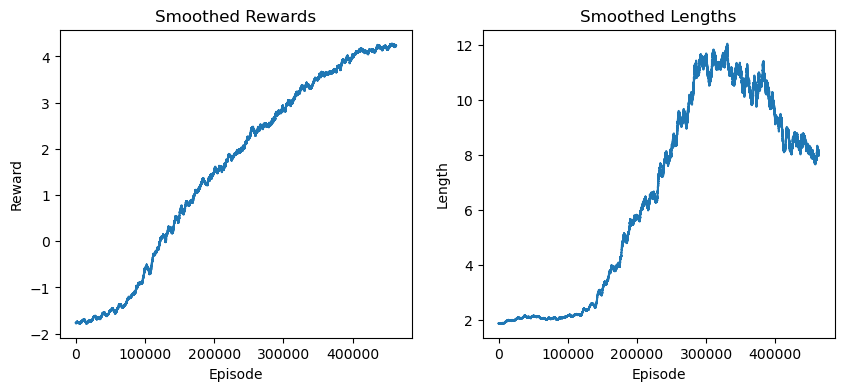

In [12]:
if load_model:
    stats_load_path = f"{load_dir}/stats.json"
    with open(stats_load_path) as f:
        stats = json.load(f)
else:
    stats = convert_numpy(vec_env.episode_custom_stats)

def smooth(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed = np.convolve(arr, kernel, mode='valid')
    return smoothed

print(f"Total timesteps: {np.sum(stats['episode_lengths'])}")
print(f"Total episodes: {len(stats['episode_lengths'])}")

rew_components = ['base', 'goal', 'wall', 'distance', 'new_cell']

for component in rew_components:
    plt.plot(smooth(stats[component], 4000), label = component)

plt.title('Component-wise Rewards')
plt.legend()
plt.show()

ep_rew_ws = 4000
ep_len_ws = 4000

fig, axs = plt.subplots(1, 2, figsize = (10,4))

ax = axs.ravel()

ax[0].plot(smooth(stats['episode_rewards'], ep_rew_ws))
ax[0].set_title('Smoothed Rewards')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].plot(smooth(stats['episode_lengths'], ep_len_ws))
ax[1].set_title('Smoothed Lengths')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Length')

plt.show()

In [13]:
model.policy

MultiInputActorCriticPolicy(
  (features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 8, kernel_size=(6, 6), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (fc): Sequential(
      (0): Linear(in_features=5184, out_features=256, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): FeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 8, kernel_size=(6, 6), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(